In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
#
import numpy as np
#
from matplotlib import pyplot as plt
#
from time import time

$$
\left\{
\begin{array}{rl}\beta u' + \gamma u = 1, & x\in(0,1) \\
u(0) = 0, &
\end{array}
\right.
$$
exact sol: $\displaystyle u(x) = \frac{1}{\gamma} - \exp\left(-\frac{\gamma}{\beta} x\right)$

Variational formulation:
$$
\left\{
\begin{array}{lr}
\text{Find }u\in L^{2}(0,1) \text{ such that:} &  \\
\displaystyle -\beta\int_{0}^{1} u v' + \gamma\int_{0}^{1} uv = \int_{0}^{1} v, & \forall\, v\in H^{1}_{0)} \\
\end{array}
\right.
$$

In [2]:
print('torch version:', torch.__version__)
#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device ='cpu'
print('device:', device)

torch version: 1.13.0
device: cpu


In [3]:
# PDE parameters
DOM_DIM = 1
beta    = .5 #.1
gamma   = 1.
RHO     = 1.1

In [4]:
# 4096 8192 16384 32768 65536 131072 262144 524288 1048576 2097152
LAYER_SIZE_u     = [1,8,1]
LAYER_SIZE_r     = [1,16,1]
TRAIN_DOM_POINTS = 2048 #1024 #8192 #4086 #256 
BATCH_SIZE       = 2048 #1024 # use the same training size to avoid using minibatches (it's slow)
LEARNING_RATE    = 0.001
STOP_CRITERIA    = 0.0001 # 0.0005
NUM_EPOCHS       = 1000 #50000
UZAWA_ITER       = 8 #4 #1 2 4 8 16 32

In [5]:
# Neural network class
class Model(nn.Module):
    def __init__(self, layer_sizes, activation=nn.Tanh(),seed=42):
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        self.seed = seed
        # Fix seed for reproducibility
        torch.manual_seed(seed)
        #
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            # Adding activation function for all but the last layer
            if i < len(layer_sizes) - 2:
                self.layers.append(self.activation)  
        # Initialize weights using Glorot initialization
        self.init_weights()  
    #
    def init_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                # Glorot initialization
                nn.init.xavier_uniform_(layer.weight)  
                # Initialize bias to zeros
                nn.init.constant_(layer.bias, 0.0)  
    #
    def forward(self, x):
        #
        inputs = x #torch.cat([x, y, z], axis=1)
        #
        for layer in self.layers:
            inputs = layer(inputs)
        return inputs

In [6]:
# Create the integration points (training points and minibatches)
torch.manual_seed(42)
train_points = torch.rand((TRAIN_DOM_POINTS,DOM_DIM), dtype=torch.float32).to(device)
train_points.requires_grad_(True)
data_loader  = DataLoader(train_points, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
# Neural network initialization (we employ three NNs)
model_r     = Model(LAYER_SIZE_r).to(device)
model_u     = Model(LAYER_SIZE_u).to(device)
model_u_old = Model(LAYER_SIZE_u).to(device)

In [8]:
# Define optimization method (training method and learning rate)
optimizer_r = torch.optim.Adam(model_r.parameters(), lr=LEARNING_RATE)
optimizer_u = torch.optim.Adam(model_u.parameters(), lr=LEARNING_RATE)

In [9]:
# Strong imposition of BCs if necessary
def u_nn_bc(x):
    nn_bc = model_u(x) #x*model_u(x)
    return nn_bc
def u_nn_old_bc(x):
    nn_bc = model_u_old(x) #x*model_u(x)
    return nn_bc
def r_nn_bc(x):
    nn_bc = (1 - x)*model_r(x) #(1. - x)*model_r(x)
    return nn_bc

In [10]:
t0 = time()
loss_r_list = []
loss_u_list = []
# Uzawa loop
for idx in range(UZAWA_ITER):
    print(f"Uzawa iteration {idx + 1}/{UZAWA_ITER}")
    print('training r')
    # loop to train r_nn
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for batch in data_loader:
            # to make the gradients zero
            optimizer_r.zero_grad() 
            #
            x      = batch
            r_nn   = r_nn_bc(x) 
            u_nn   = u_nn_bc(x)
            #
            #
            r_nn_x = torch.autograd.grad(r_nn, x, 
                                         create_graph=True, 
                                         grad_outputs=torch.ones_like(r_nn)
                                        )[0]
            #
            loss_r1 = (1/2)*torch.mean((-beta*r_nn_x + gamma*r_nn)**2) # (1/2)*||r||_{V}^2
            loss_r2 = torch.mean(r_nn)                                 # l(r)
            loss_r3 = torch.mean(-beta*u_nn*r_nn_x + gamma*u_nn*r_nn)  # b(u^k,r)
            loss_r  = loss_r1 - loss_r2 + loss_r3                      # r^{k+1} = argmin (1/2)*||r||_{V}^2 - l(r) + b(u^k,r)
            running_loss += loss_r.item()
            # This is for computing gradients using backward propagation
            loss_r.backward()#retain_graph=True) 
            optimizer_r.step() # 
        loss_r_list.append(running_loss / len(data_loader))
        # if epoch % 200 == 0:
        #     print(f"Epoch: {epoch} - Loss(r): {loss_r.item():>1.6e}")
    # Save the r model at the idx-th iteration
    torch.save(model_r.state_dict(), f"model_r_weights_{idx}.pth")
    # Define a NN for u at the previous step (u_nn^{k})
    state_dict = model_u.state_dict()
    model_u_old.load_state_dict(state_dict)
    #
    print('training u')
    # loop to train u_nn
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for batch in data_loader:
            # to make the gradients zero
            optimizer_u.zero_grad() 
            #
            x        = batch
            r_nn     = r_nn_bc(x)
            u_nn     = u_nn_bc(x)
            u_nn_old = u_nn_old_bc(x)         
            #
            r_nn_x = torch.autograd.grad(r_nn, x, 
                                         create_graph=True, 
                                         grad_outputs=torch.ones_like(r_nn)
                                        )[0]
            #
            loss_u1 = (1/2)*torch.mean((u_nn)**2)                     # (1/2)*||u||_{U}^2
            loss_u2 = torch.mean(u_nn*u_nn_old)                       # (u,u^{k})_{U}
            loss_u3 = torch.mean(-beta*u_nn*r_nn_x + gamma*u_nn*r_nn) # rho*b(u,r^{k+1})
            loss_u  = loss_u1 - loss_u2 - RHO*loss_u3                 # u^{k+1} = argmin (1/2)*||u||_{U}^2 - (u,u^{k})_{U}
            running_loss += loss_u.item()                             #                                    - rho*b(u,r^{k+1})
            # This is for computing gradients using backward propagation
            loss_u.backward() #retain_graph=True) 
            optimizer_u.step() # 
        loss_u_list.append(running_loss / len(data_loader))
        # if epoch % 200 == 0:
        #     print(f"Epoch: {epoch} - Loss(u): {loss_u.item():>1.6e}")
    # Save the u model at the idx-th iteration
    torch.save(model_u.state_dict(), f"model_u_weights_{idx}.pth")
    #
print(f'time: {(time() - t0)/60} [min]')

Uzawa iteration 1/8
training r
training u
Uzawa iteration 2/8
training r
training u
Uzawa iteration 3/8
training r
training u
Uzawa iteration 4/8
training r
training u
Uzawa iteration 5/8
training r
training u
Uzawa iteration 6/8
training r
training u
Uzawa iteration 7/8
training r
training u
Uzawa iteration 8/8
training r
training u
time: 9.451913793881735 [min]


In [11]:
def u_exact(x):
    if beta == 0.:
        aux = torch.ones_like(x)
    elif gamma == 0.:
        aux = x
    else:
        aux = 1/gamma - torch.exp(-gamma*x/beta)/gamma
    return aux

In [12]:
x_test = torch.linspace(0.,1.,128).reshape(-1,1).to(device)

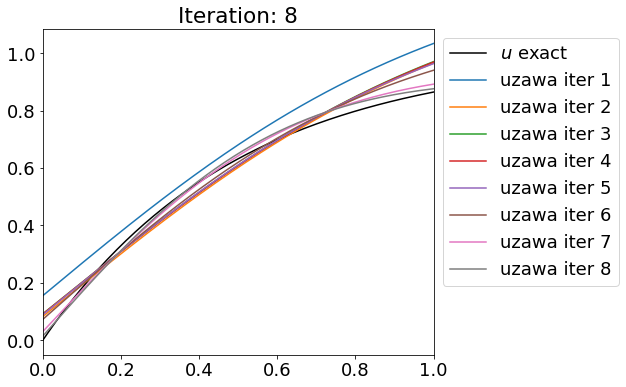

In [13]:
plt.figure(figsize=(7,6))
#
plt.rcParams.update({'font.size': 18})
#
plt.plot(x_test.cpu().numpy(),u_exact(x_test).cpu(),label='$u$ exact',color='black')
for idx in range(UZAWA_ITER):
    model_u.load_state_dict(torch.load(f"model_u_weights_{idx}.pth", map_location=device))
    u_test = u_nn_bc(x_test) 
    plt.plot(x_test.cpu().numpy(),u_test.cpu().detach().numpy(),label=f"uzawa iter {idx + 1}")
plt.title(f"Iteration: {UZAWA_ITER}")
plt.xlim(0.,1.)
#plt.ylim(-0.2,1.2)
plt.legend(bbox_to_anchor=(1., 1.))
plt.show()

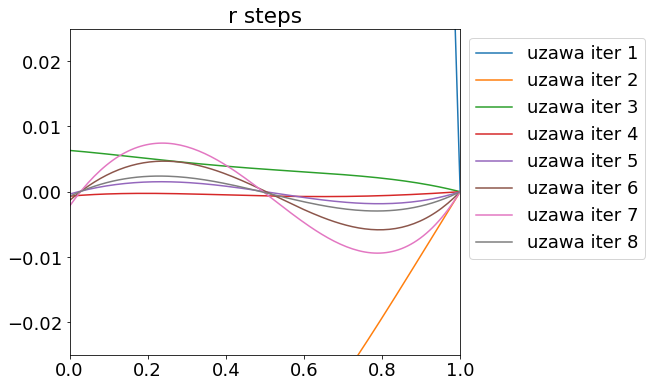

In [17]:
plt.figure(figsize=(7,6))
#
plt.rcParams.update({'font.size': 18})
#
for idx in range(UZAWA_ITER):
    model_r.load_state_dict(torch.load(f"model_r_weights_{idx}.pth", map_location=device))
    r_test = r_nn_bc(x_test) 
    plt.plot(x_test.cpu().numpy(),r_test.cpu().detach().numpy(),label=f"uzawa iter {idx + 1}")
plt.title(f"r steps")
plt.xlim(0.,1.)
plt.ylim(-0.025,.025)
plt.legend(bbox_to_anchor=(1., 1.))
plt.show()

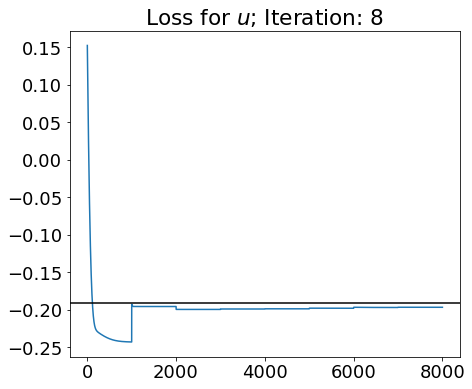

In [15]:
plt.figure(figsize=(7,6))
#
plt.rcParams.update({'font.size': 18})
#
plt.title(f"Loss for $u$; Iteration: {UZAWA_ITER}")
plt.plot(loss_u_list)
Ju_min = -(1/(gamma**2) - (beta/(2*gamma**3))*(np.exp(-2*gamma/beta) - 4*np.exp(-gamma/beta) + 3))/2
plt.axhline(y=Ju_min,color='black')
#
# plt.savefig(f"advec_reac/Loss_u_{UZAWA_ITER}_{BATCH_SIZE}.png", dpi=300, facecolor=None, edgecolor=None,
#             orientation='portrait', format='png',transparent=True, 
#             bbox_inches='tight', pad_inches=0.1, metadata=None)

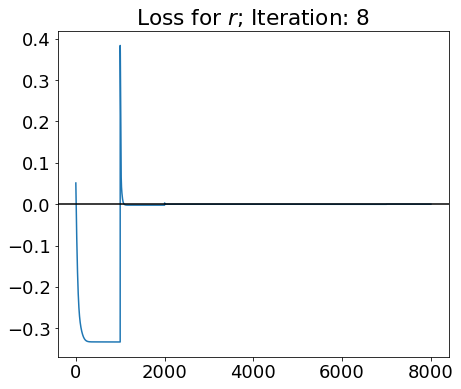

In [16]:
plt.figure(figsize=(7,6))
#
plt.rcParams.update({'font.size': 18})
#
plt.title(f"Loss for $r$; Iteration: {UZAWA_ITER}")
plt.plot(loss_r_list)
plt.axhline(y=0.,color='black')
#
# plt.savefig(f"advec_reac/Loss_r_{UZAWA_ITER}_{BATCH_SIZE}.png", dpi=300, facecolor=None, edgecolor=None,
#             orientation='portrait', format='png',transparent=True, 
#             bbox_inches='tight', pad_inches=0.1, metadata=None)